## Data preparation & cleaning

In [1]:
# Environment setup
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRegressor

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

Let's import the data take a brief view first.

In [2]:
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

df0 = df_train_raw.copy() #df0 is for cleaning and EDA only
df0.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Let's change column names to lower case, replace long name, and drop `id` column.

In [3]:
df0.columns = df0.columns.str.lower()
df0.rename(columns={'family_history_with_overweight':'history'}, inplace=True)
df0.drop(columns=['id'], inplace=True)
df0.head()

,gender,age,height,weight,history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gender      20758 non-null  object 
 1   age         20758 non-null  float64
 2   height      20758 non-null  float64
 3   weight      20758 non-null  float64
 4   history     20758 non-null  object 
 5   favc        20758 non-null  object 
 6   fcvc        20758 non-null  float64
 7   ncp         20758 non-null  float64
 8   caec        20758 non-null  object 
 9   smoke       20758 non-null  object 
 10  ch2o        20758 non-null  float64
 11  scc         20758 non-null  object 
 12  faf         20758 non-null  float64
 13  tue         20758 non-null  float64
 14  calc        20758 non-null  object 
 15  mtrans      20758 non-null  object 
 16  nobeyesdad  20758 non-null  object 
dtypes: float64(8), object(9)
memory usage: 2.7+ MB


There are 17 columns and 20,758 rows, no missing value.  
Now let's make sense of all the rows. Google search yields below info:

| **Column** | **Description**                                                                                                                                                      |
|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| FAVC       | Frequency of consuming high-calorie foods and contains two levels, where Yes and No mean high-frequency and low-frequency intake of high caloric foods respectively. |
| FCVC       | Frequency of vegetable intake in meals, where FCVC > 2 means positive vegetable intake in every meal and FCVC ≤ 2 means zero vegetable intake for some meals.        |
| NCP        | Number of main meals in a day.                                                                                                                                       |
| CAEC       | Frequency of sub-meals between main meals.                                                                                                                           |
| CH2O       | Amount of daily water intake in liters.                                                                                                                              |
| SCC        | Binary indicator of food calorie monitoring and comprises two levels: Yes and No.                                                                                    |
| FAF        | Frequency of physical activity.                                                                                                                                      |
| TUE        | Time spent on technological devices.                                                                                                                                 |
| CALC       | Alcohol intake levels.                                  |
| MTRANS     | The usual means of transportation and consists of five levels: Automobile, Motorbike, Bike, Public Transportation and Walking                                        |
| NObeyesdad | Obesity level.                                                                                                                                                       |

The string type columns should be either boolean or categorical. Let's transform them.

In [5]:
for col in df0.columns:
    if df0[col].dtype == 'object':
        print(col, set(df0[col]))

gender {'Male', 'Female'}
history {'no', 'yes'}
favc {'no', 'yes'}
caec {'Sometimes', 'no', 'Always', 'Frequently'}
smoke {'no', 'yes'}
scc {'no', 'yes'}
calc {'Sometimes', 'no', 'Frequently'}
mtrans {'Bike', 'Motorbike', 'Automobile', 'Public_Transportation', 'Walking'}
nobeyesdad {'Obesity_Type_II', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_III', 'Insufficient_Weight', 'Normal_Weight'}


In [6]:
# tranform boolean columns
for col in ['history', 'favc', 'smoke', 'scc']:
    df0[col] = df0[col].map({'yes': True, 'no': False})

# transfer categorical columns
df0['gender'] = pd.Categorical(df0['gender'], 
                               categories=['Male', 'Female'],
                               ordered=True)
df0['caec'] = pd.Categorical(df0['caec'],
                             categories=['no', 'Sometimes', 'Frequently', 'Always'],
                             ordered=True)
df0['calc'] = pd.Categorical(df0['calc'],
                             categories=['no', 'Sometimes', 'Frequently'],
                             ordered=True)
df0['mtrans'] = pd.Categorical(df0['mtrans'],
                               categories=['Walking', 'Public_Transportation', 'Bike', 
                                           'Motorbike', 'Automobile'],
                               ordered=True)
df0['nobeyesdad'] = pd.Categorical(df0['nobeyesdad'],
                                   categories=['Insufficient_Weight', 'Normal_Weight', 
                                               'Overweight_Level_I', 'Overweight_Level_II', 
                                               'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 
                                   ordered=True)

# show result
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gender      20758 non-null  category
 1   age         20758 non-null  float64 
 2   height      20758 non-null  float64 
 3   weight      20758 non-null  float64 
 4   history     20758 non-null  bool    
 5   favc        20758 non-null  bool    
 6   fcvc        20758 non-null  float64 
 7   ncp         20758 non-null  float64 
 8   caec        20758 non-null  category
 9   smoke       20758 non-null  bool    
 10  ch2o        20758 non-null  float64 
 11  scc         20758 non-null  bool    
 12  faf         20758 non-null  float64 
 13  tue         20758 non-null  float64 
 14  calc        20758 non-null  category
 15  mtrans      20758 non-null  category
 16  nobeyesdad  20758 non-null  category
dtypes: bool(4), category(5), float64(8)
memory usage: 1.4 MB


In [7]:
df0.duplicated().sum()

0

There is no duplicate entry.

In [8]:
df0.describe(include='all')

,gender,age,height,weight,history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
count,20758,20758.000000,20758.000000,20758.000000,20758,20758,20758.000000,20758.000000,20758,20758,20758.000000,20758,20758.000000,20758.000000,20758,20758,20758
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,Female,NaN,NaN,NaN,True,True,NaN,NaN,Sometimes,False,NaN,False,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,NaN,NaN,NaN,17014,18982,NaN,NaN,17529,20513,NaN,20071,NaN,NaN,15066,16687,4046
mean,NaN,23.841804,1.700245,87.887768,NaN,NaN,2.445908,2.761332,NaN,NaN,2.029418,NaN,0.981747,0.616756,NaN,NaN,NaN
std,NaN,5.688072,0.087312,26.379443,NaN,NaN,0.533218,0.705375,NaN,NaN,0.608467,NaN,0.838302,0.602113,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,20.000000,1.631856,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.792022,NaN,0.008013,0.000000,NaN,NaN,NaN
50%,NaN,22.815416,1.700000,84.064875,NaN,NaN,2.393837,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.573887,NaN,NaN,NaN
75%,NaN,26.000000,1.762887,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.549617,NaN,1.587406,1.000000,NaN,NaN,NaN


Overall there seems no abnormal data.

According to the description of FCVC, it is better to transform this column to boolean type also.

In [9]:
df0['fcvc'] = df0['fcvc'].round(2) > 2
df0['fcvc'].dtype

dtype('bool')

## EDA and feature engineer

Let's make a new column `bmi` and drop `height`, `weight`.

In [10]:
df0['bmi'] = df0['weight'] / np.square(df0['height'])
df0.drop(columns=['height', 'weight'], inplace=True)

df0.columns

Index(['gender', 'age', 'history', 'favc', 'fcvc', 'ncp', 'caec', 'smoke',
       'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'bmi'],
      dtype='object')

For each categorical column, let's make a new column to store the encode number for numerical analysis.

In [11]:
for col in df0.columns:
    if df0[col].dtype == 'category':
        df0[col+'_lvl'] = df0[col].cat.codes

df0.columns

Index(['gender', 'age', 'history', 'favc', 'fcvc', 'ncp', 'caec', 'smoke',
       'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'bmi',
       'gender_lvl', 'caec_lvl', 'calc_lvl', 'mtrans_lvl', 'nobeyesdad_lvl'],
      dtype='object')

Let's check data balance (for categorical features) and distribution (for numerical features).

In [12]:
for col in df0.columns[:16]:
    if df0[col].dtype in ['category', 'bool']:
        print(df0[col].value_counts(normalize=True))
        print()

gender
Female    0.502071
Male      0.497929
Name: proportion, dtype: float64

history
True     0.819636
False    0.180364
Name: proportion, dtype: float64

favc
True     0.914443
False    0.085557
Name: proportion, dtype: float64

fcvc
True     0.561326
False    0.438674
Name: proportion, dtype: float64

caec
Sometimes     0.844446
Frequently    0.119087
Always        0.023027
no            0.013441
Name: proportion, dtype: float64

smoke
False    0.988197
True     0.011803
Name: proportion, dtype: float64

scc
False    0.966904
True     0.033096
Name: proportion, dtype: float64

calc
Sometimes     0.725792
no            0.248723
Frequently    0.025484
Name: proportion, dtype: float64

mtrans
Public_Transportation    0.803883
Automobile               0.170248
Walking                  0.022497
Motorbike                0.001831
Bike                     0.001542
Name: proportion, dtype: float64

nobeyesdad
Obesity_Type_III       0.194913
Obesity_Type_II        0.156470
Normal_Weight     

Some features (favc, smoke, scc) show very high data imbalance. We need to take special care to split train and validate datasets.

Some features (caec, calc, mtrans) show very low representative for some categories. Luckily these features all should be encoded by order, so maybe not much affecting the model performance.

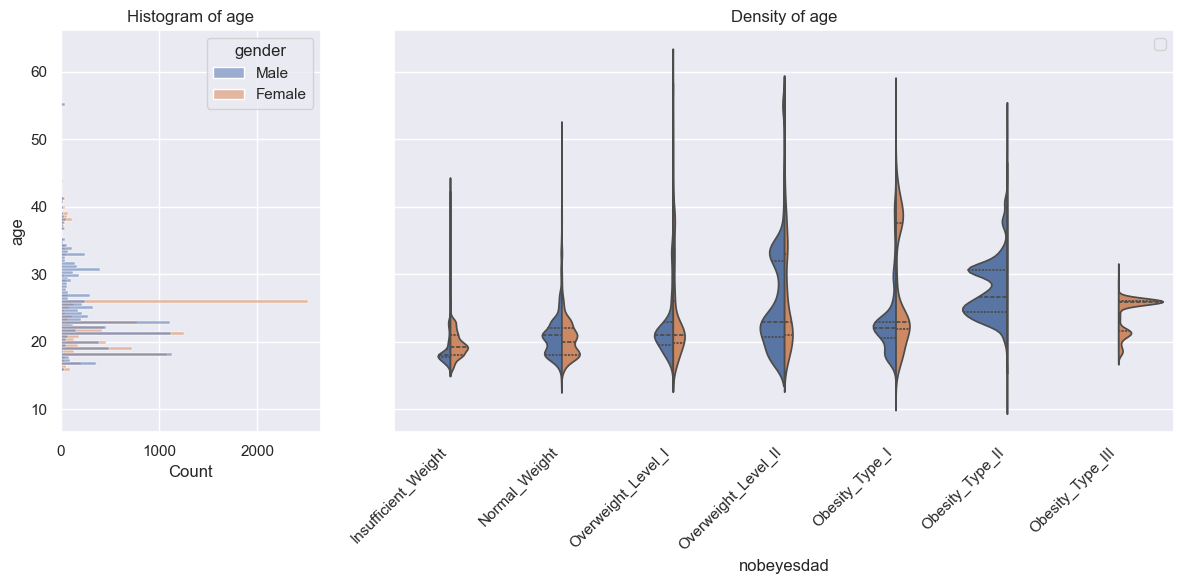

In [13]:
col = 'age'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- Young (<30) people obesity levels are widely distributed.  
- Mid age and higher are mostly overweight level II to obesity type II levels.
- `Obesity_Type_III` distribution is very different from other obesity types.
- Male and female show bigger difference with higher obesity types.

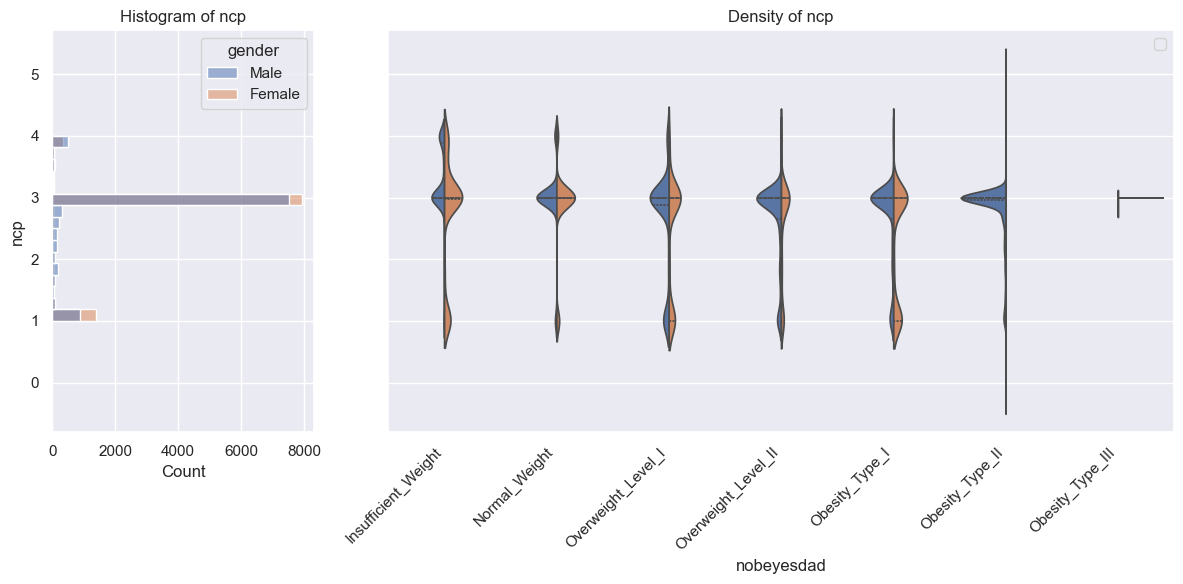

In [14]:
col = 'ncp'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- People eat only 1 meal per day has less extreme obesity issue, likely due to they are on diet.
- People eat 4 meals per day has little obesity issue. Maybe they pay more attention on healthy diet.
- Males tends to eat more meals per day than females.

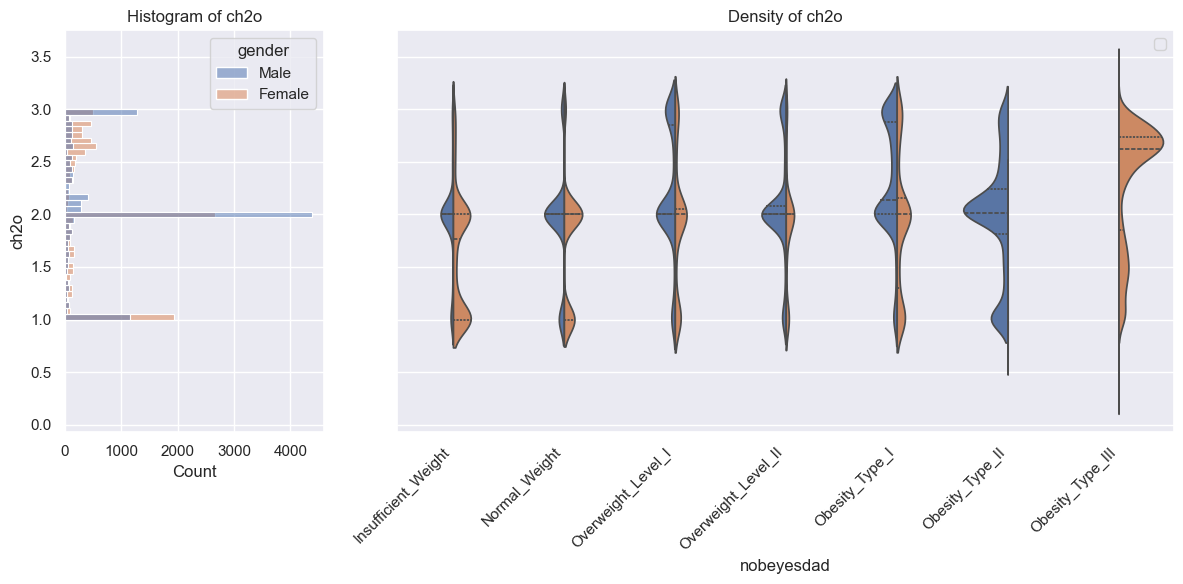

In [15]:
col = 'ch2o'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

`Obesity_Type_III` and `Obesity_Type_II` distributions show very big gender bias.

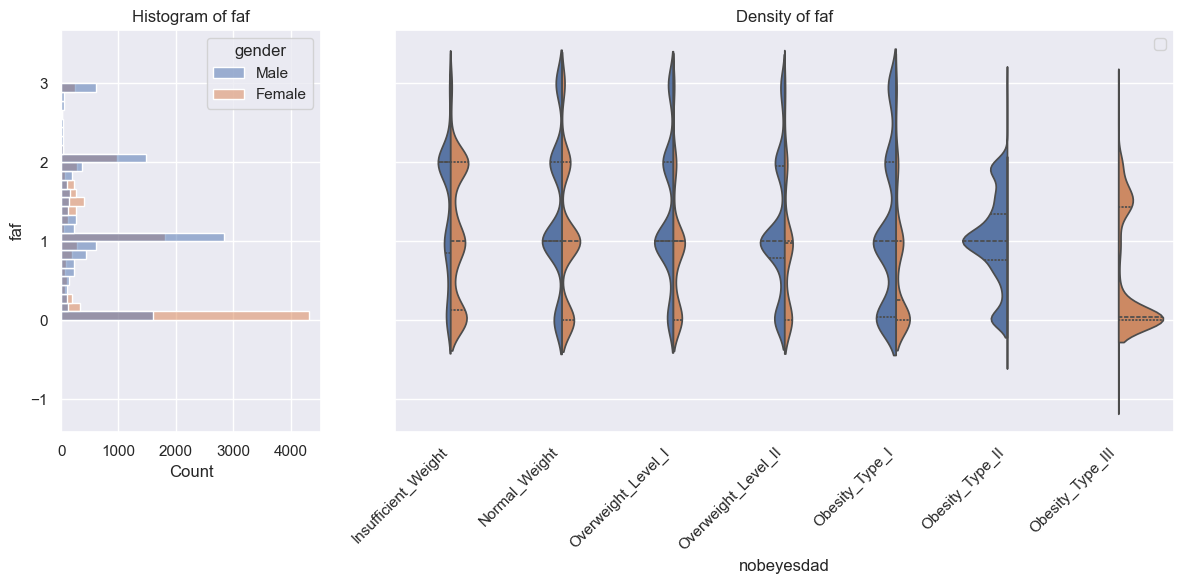

In [16]:
col = 'faf'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

`Obesity_Type_III` risk is high for people who don't have physical activity, which is expected. However, why is there a peak ~1.5 for females? Maybe they start to exercise for health concern?

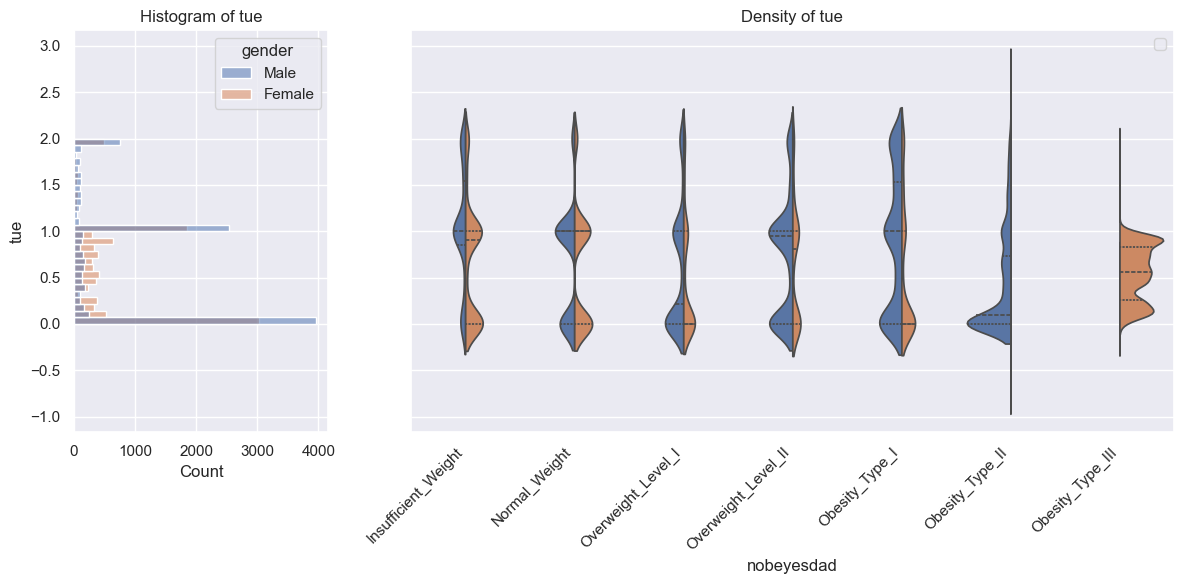

In [17]:
col = 'tue'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

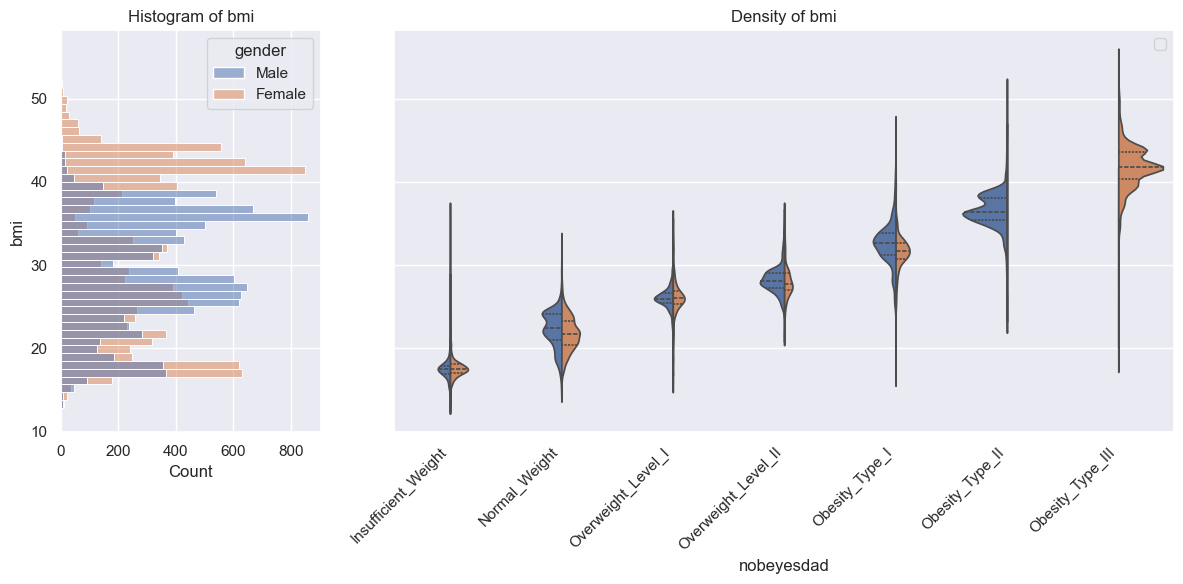

In [18]:
col = 'bmi'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- `bmi` shows strong correlation with obesity status, as expected.
- Female tends to have higher `bmi` when in `Obesity_Type_III` status.

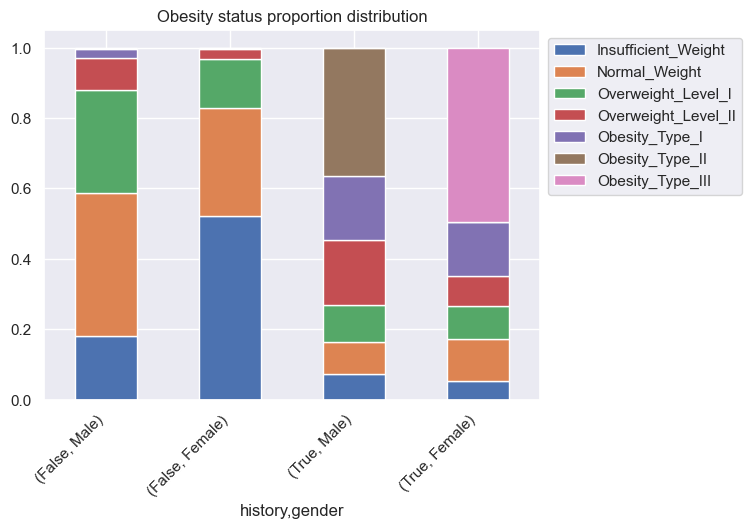

In [19]:
col = 'history'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- With family obesity history, people is more likely to have severe obesity
    - Male tends to have type II obesity
    - Female tends to have type III obesity 

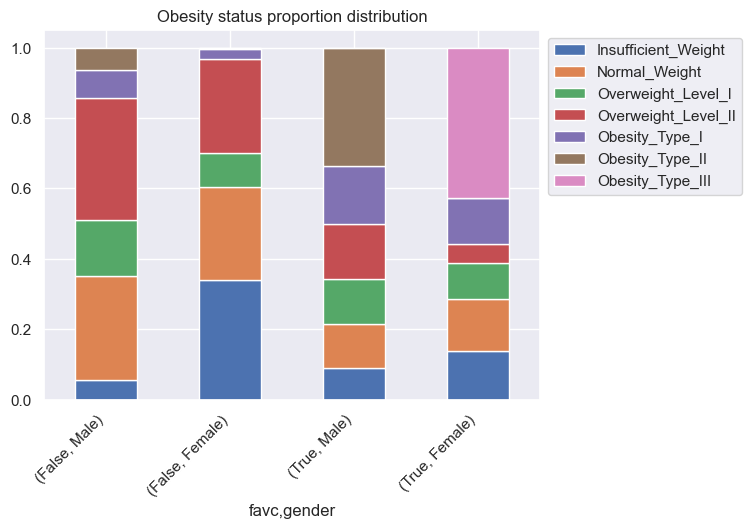

In [20]:
col = 'favc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

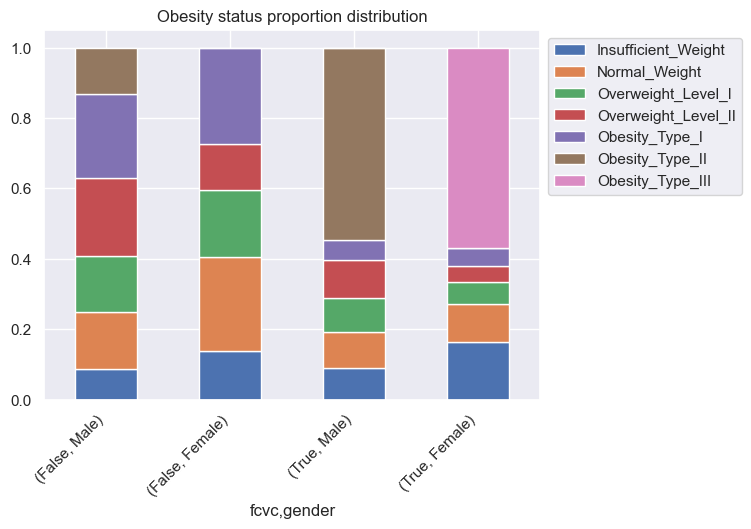

In [21]:
col = 'fcvc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Eat more vegetable has higher obesity risk???
    - Maybe they eat salad with lots of high calorie source?
    - Maybe they eat more food overall?

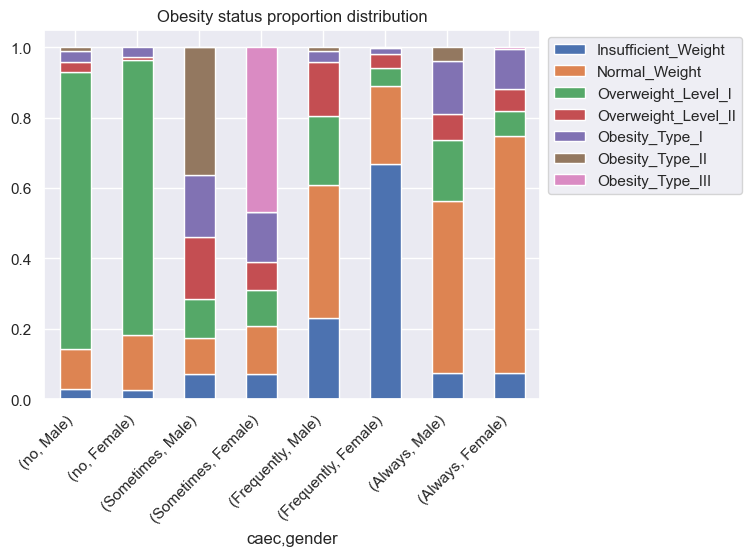

In [22]:
col = 'caec'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Sub meal frequency does NOT show linear correlation to obesity risk
    - `Sometimes` sub meal has very high obesity risk, maybe people sometimes take sub meal is for satisfaction purpose.
    - We need to change the order of `caec` categories inorder to have linear correlation with obesity risk.

In [23]:
# Change the order of 'caec'
df0['caec'] = df0['caec'].cat.reorder_categories(['Frequently', 'Always', 'no', 'Sometimes'], True)
df0['caec_lvl'] = df0['caec'].cat.codes

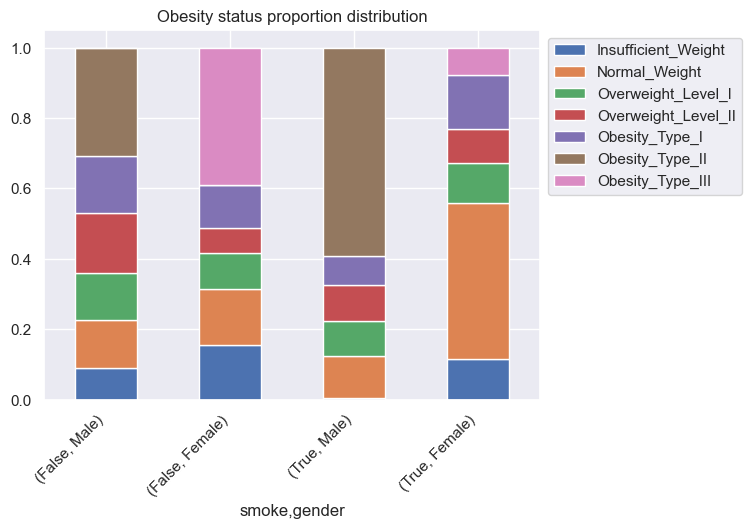

In [24]:
col = 'smoke'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

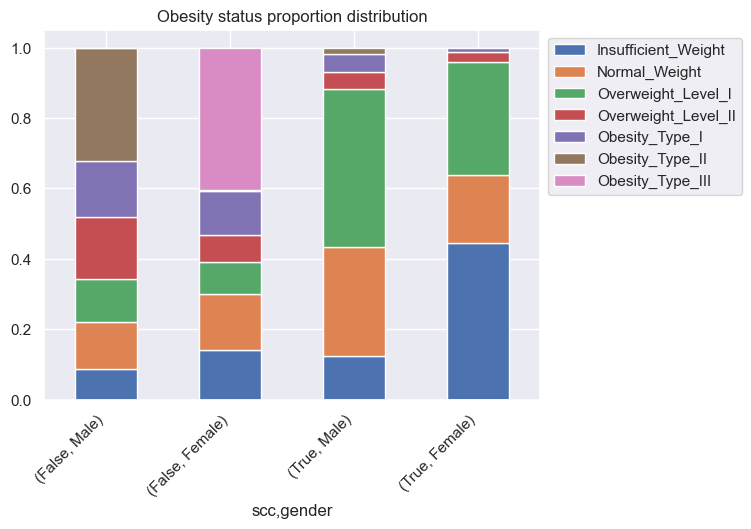

In [25]:
col = 'scc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Clearly people monitor food calorie is healthier with much less obesity risk.

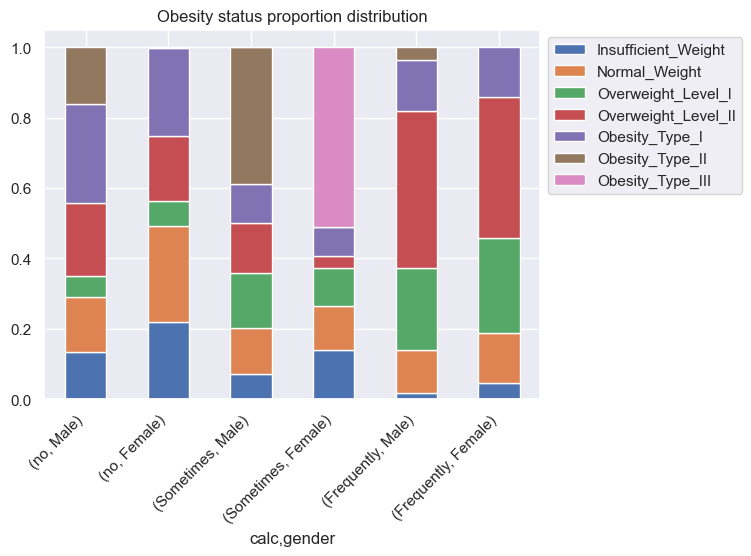

In [26]:
col = 'calc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- There is trend, but NOT linear correlation.
    - People who drink `Sometimes` has very high obesity risk, maybe they drink for satisfaction and consumes lots of high calorie side foods together.
    - We shall change category order also.

In [27]:
# Change the order of 'calc'
df0['calc'] = df0['calc'].cat.reorder_categories(['Frequently', 'no', 'Sometimes'], True)
df0['calc_lvl'] = df0['calc'].cat.codes

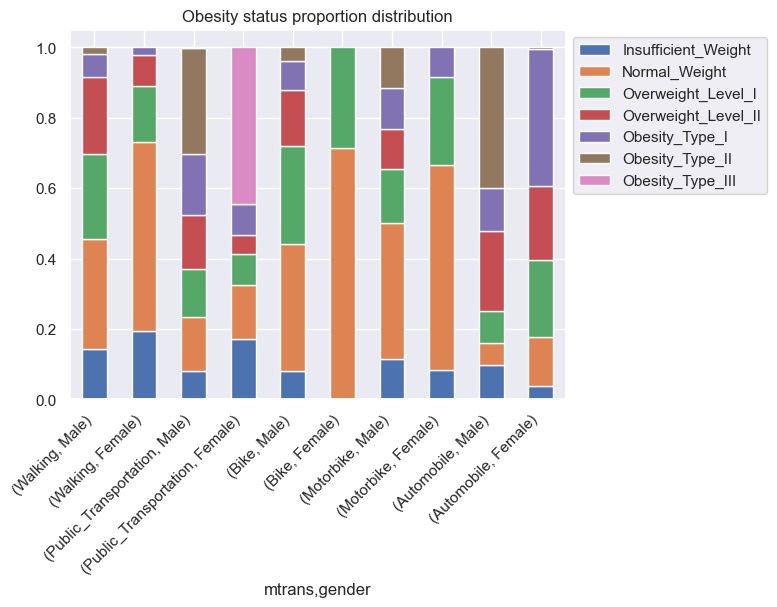

In [28]:
col = 'mtrans'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

In [29]:
# Change the order of 'mtrans'
df0['mtrans'] = df0['mtrans'].cat.\
    reorder_categories(['Walking', 'Bike', 'Motorbike', 'Automobile', 'Public_Transportation'], True)
df0['mtrans_lvl'] = df0['mtrans'].cat.codes

Now let's check the correlation matrix.

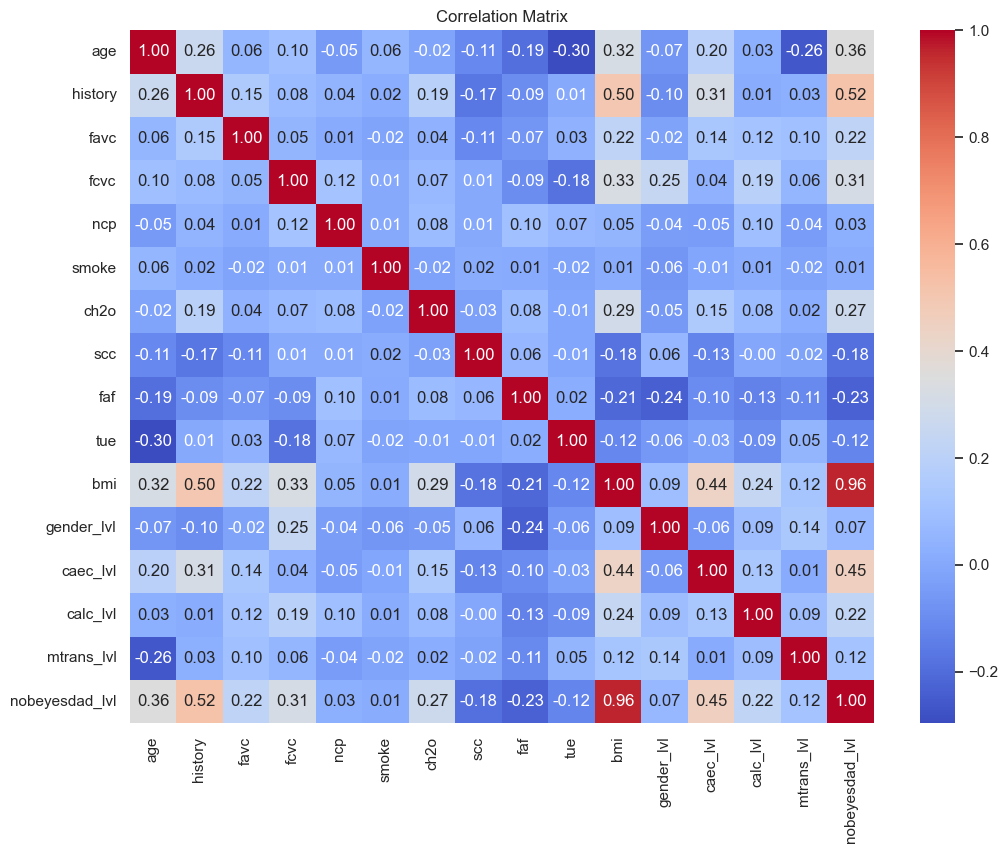

In [30]:
plt.figure(figsize=(12, 9))
sns.heatmap(df0.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Summary of EDA**  
- `bmi` has the strongest correlation to `NObeyesdad`, followed by `history`, `caec`, `age`, etc.
- Male and female with type II and type III obesity have very different features.
- People with healthier life style (e.g. walking, monitor food calorie, less satisfaction alchohol and sub meal consumption, etc.) has less obesity risk.

## Model Construction

In [31]:
# prepare train and validate datasets
cat_cols = [col for col in df0.columns if df0[col].dtype == 'category']
Xy_df = df0.drop(columns=cat_cols)

# prepare stratify standard column
Xy_df['stratify'] = np.zeros(Xy_df.shape[0])
for col in ['favc', 'smoke', 'scc']:
    Xy_df['stratify'] = Xy_df['stratify'] * 10 + Xy_df[col]
Xy_df['stratify'] = Xy_df['stratify'].convert_dtypes('int')

# select X, y
X = Xy_df.drop(columns=['stratify', 'nobeyesdad_lvl'])
y = Xy_df['nobeyesdad_lvl']

# split train and validate datasets
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.25, stratify=Xy_df['stratify'], random_state=42)

# reset index for split datasets, otherwise later correlation factor calculation will be wrong
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

**Plan**  
- Models to try
    1. KNN
    2. RandomForest
    3. XGBoost (both tree and linear boosters)
- Classifier vs. regressor (experiment)
    - Though the object of this work is classification, it is possible to use regressor models as the dependent variable is ordinally coded.
    - We can try if regressor version of same model can effect the score or not.
- Optional ideas
    1. Change categorical variable codes to better linearly fit with dependent variable code.
    2. Seperate male and female data to build models seperately.

### K-Nearest Neighbors (KNN)

#### **Model 1:** KNN classifier

Firstly we need to transform the independent features.  
- Normalize all features for correct distance calculation.

In [32]:
# for splitted train/val datasets, avoid data leak
power_transformer_train = PowerTransformer()
power_transformer_train.fit(X_train)

# for final model preperation
power_transformer_final = PowerTransformer()
power_transformer_final.fit(X)

X_train_norm = power_transformer_train.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_val_norm = power_transformer_train.transform(X_val)
X_val_norm = pd.DataFrame(X_val_norm, columns=X_val.columns)

Let's fit the model with default setting first, then try to improve with hyper parameter tuning.

In [33]:
model_1_default = KNeighborsClassifier(n_jobs=-1)
# model_1_default.fit(X_train_norm, y_train)

In [34]:
# pickle.dump(model_1_default, open('model_1_default.pickle', 'wb'))
model_1_default = pickle.load(open('model_1_default.pickle', 'rb'))

In [35]:
model_summary = {'id': [], 'model': [], 'transformer': [], 'accuracy_default': [], 
                 'accuracy_tuned': [], 'comment': []}
model_summary['id'].append(1)
model_summary['model'].append('KNN clf')
model_summary['transformer'].append('PowerTransformer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_1_default.predict(X_val_norm)))

print(f"KNN classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

KNN classifier (default) accuracy (val) = 74.1%


In [36]:
# hyper parameter tuning
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
model_1_tune = GridSearchCV(knn_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_1_tune.fit(X_train_norm, y_train)

In [37]:
# pickle.dump(model_1_tune, open('model_1_tune.pickle', 'wb'))
model_1_tune = pickle.load(open('model_1_tune.pickle', 'rb'))

In [38]:
model_1_tune.best_params_

{'n_neighbors': 14, 'p': 1, 'weights': 'distance'}

In [39]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_1_tune.predict(X_val_norm)))
model_summary['comment'].append('')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,


In [40]:
# prepare final model trained on all data
X_norm = power_transformer_final.transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)

model_1_final = model_1_tune.best_estimator_
# model_1_final.fit(X_norm, y)

In [41]:
# pickle.dump(model_1_final, open('model_1_final.pickle', 'wb'))
model_1_final = pickle.load(open('model_1_final.pickle', 'rb'))

In [42]:
## prepare test data
df_test_id = df_test_raw[['id']] # reserve id
df1 = df_test_raw.drop(columns=['id'])
df1.columns = df1.columns.str.lower()
df1.rename(columns={'family_history_with_overweight':'history'}, inplace=True)

# tranform boolean columns
for col in ['history', 'favc', 'smoke', 'scc']:
    df1[col] = df1[col].map({'yes': True, 'no': False})

# transfer categorical columns
df1['gender'] = pd.Categorical(df1['gender'], 
                               categories=['Male', 'Female'],
                               ordered=True)
df1['caec'] = pd.Categorical(df1['caec'],
                             categories=['Frequently', 'Always', 'no', 'Sometimes'],
                             ordered=True)
df1['calc'] = pd.Categorical(df1['calc'],
                             categories=['Frequently', 'no', 'Sometimes'],
                             ordered=True)
df1['mtrans'] = pd.Categorical(df1['mtrans'],
                               categories=['Walking', 'Bike', 'Motorbike', 
                                           'Automobile', 'Public_Transportation'],
                               ordered=True)

df1['fcvc'] = df1['fcvc'].round(2) > 2

df1['bmi'] = df1['weight'] / np.square(df1['height'])
df1.drop(columns=['height', 'weight'], inplace=True)

for col in df1.columns:
    if df1[col].dtype == 'category':
        df1[col+'_lvl'] = df1[col].cat.codes

cat_cols = [col for col in df1.columns if df1[col].dtype == 'category']
X_test = df1.drop(columns=cat_cols)

X_test_norm = power_transformer_final.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

In [43]:
# prepare model_1 submission file
nobeyesdad_list = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                   'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                   'Obesity_Type_III']
y_pred = model_1_final.predict(X_test_norm)
df_model_1 = df_test_id.copy()
df_model_1['NObeyesdad'] = y_pred
df_model_1['NObeyesdad'] = df_model_1['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_1.to_csv('model_1_submission.csv', index=False)

#### **Model 2:** KNN regressor

We don't need to do extra data preparation. Only need to convert the model prediction value (float) to the target codes (int).

In [44]:
model_2_default = KNeighborsRegressor(n_jobs=-1)
# model_2_default.fit(X_train_norm, y_train)

In [45]:
# pickle.dump(model_2_default, open('model_2_default.pickle', 'wb'))
model_2_default = pickle.load(open('model_2_default.pickle', 'rb'))

In [46]:
def reg_to_clf(y_pred):
    """convert regressor prediction results to classifier results
    """
    result = []
    for y in y_pred:
        y = np.round(y, 0)
        y = max(y, 0)
        y = min(y, 6)
        result.append(int(y))
    return np.array(result)

model_summary['id'].append(2)
model_summary['model'].append('KNN reg')
model_summary['transformer'].append('PowerTransformer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, reg_to_clf(model_2_default.predict(X_val_norm))))

print(f"KNN regressor (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

KNN regressor (default) accuracy (val) = 72.1%


In [47]:
# hyper parameter tuning
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
model_2_tune = GridSearchCV(knn_reg, param_grid, cv=4, scoring=['neg_mean_absolute_error'], 
                            refit='neg_mean_absolute_error', n_jobs=-1)
# model_2_tune.fit(X_train_norm, y_train)

In [48]:
# pickle.dump(model_2_tune, open('model_2_tune.pickle', 'wb'))
model_2_tune = pickle.load(open('model_2_tune.pickle', 'rb'))

In [49]:
model_2_tune.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [50]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, 
            reg_to_clf(model_2_tune.predict(X_val_norm))))
model_summary['comment'].append('')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,


Regressor model is slightly worse than classifier model.

In [51]:
# prepare final model
model_2_final = model_2_tune.best_estimator_
# model_2_final.fit(X_norm, y)

In [52]:
# pickle.dump(model_2_final, open('model_2_final.pickle', 'wb'))
model_2_final = pickle.load(open('model_2_final.pickle', 'rb'))

In [53]:
# prepare model_2 submission file
y_pred = reg_to_clf(model_2_final.predict(X_test_norm))
df_model_2 = df_test_id.copy()
df_model_2['NObeyesdad'] = y_pred
df_model_2['NObeyesdad'] = df_model_2['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_2.to_csv('model_2_submission.csv', index=False)

#### **Model 3:** KNN classifier (weighted feature distribution)

**Idea**  
- In previous KNN models, all independent features were transformed to be close to normal distribution with standard distribution.
    - Standard distribution actually assumes same prediction power in KNN model.
- However, from correlation matrix we know the prediction power of each feature is different.
- Maybe we can put a weight on the feature standard deviation so its prediction power can be reflected in KNN model?
    - In this experiment, we use $R$ score as the weight.

In [54]:
r_score_final = X_norm.corrwith(y) # linear correlation factor
r_score_train = X_train_norm.corrwith(y_train)
X_norm_r = X_norm.copy()
X_train_norm_r = X_train_norm.copy()
X_val_norm_r = X_val_norm.copy()
for col in X_norm.columns:
    r_train = r_score_train[col]
    r_final = r_score_final[col]
    X_norm_r[col] = X_norm_r[col] * r_final
    X_train_norm_r[col] = X_train_norm_r[col] * r_train
    X_val_norm_r[col] = X_val_norm_r[col] * r_train

In [55]:
model_3_default = KNeighborsClassifier(n_jobs=-1)
# model_3_default.fit(X_train_norm_r, y_train)

In [56]:
# pickle.dump(model_3_default, open('model_3_default.pickle', 'wb'))
model_3_default = pickle.load(open('model_3_default.pickle', 'rb'))

In [57]:
model_summary['id'].append(3)
model_summary['model'].append('KNN clf')
model_summary['transformer'].append('PowerTransformer*r')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_3_default.predict(X_val_norm_r)))

print(f"KNN classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

KNN classifier (default) accuracy (val) = 84.1%


In [58]:
# hyper parameter tuning
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
model_3_tune = GridSearchCV(knn_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_3_tune.fit(X_train_norm_r, y_train)

In [59]:
# pickle.dump(model_3_tune, open('model_3_tune.pickle', 'wb'))
model_3_tune = pickle.load(open('model_3_tune.pickle', 'rb'))

In [60]:
model_3_tune.best_params_

{'n_neighbors': 28, 'p': 1, 'weights': 'distance'}

In [61]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_3_tune.predict(X_val_norm_r)))
model_summary['comment'].append('weight: r score')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score


It works!  
Accuracy score improves **7.9%**!

In [62]:
# prepare final model
model_3_final = model_3_tune.best_estimator_
# model_3_final.fit(X_norm_r, y)

In [63]:
# pickle.dump(model_3_final, open('model_3_final.pickle', 'wb'))
model_3_final = pickle.load(open('model_3_final.pickle', 'rb'))

In [64]:
# prepare model_3 submission file
X_test_norm_r = X_test_norm.copy()
for col in X_test_norm.columns:
    r_final = r_score_final[col]
    X_test_norm_r[col] = X_test_norm_r[col] * r_final

y_pred = model_3_final.predict(X_test_norm_r)
df_model_3 = df_test_id.copy()
df_model_3['NObeyesdad'] = y_pred
df_model_3['NObeyesdad'] = df_model_3['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_3.to_csv('model_3_submission.csv', index=False)

#### **Model 4:** KNN regressor (weighted feature distribution)

In [65]:
model_4_default = KNeighborsRegressor(n_jobs=-1)
# model_4_default.fit(X_train_norm_r, y_train)

In [66]:
# pickle.dump(model_4_default, open('model_4_default.pickle', 'wb'))
model_4_default = pickle.load(open('model_4_default.pickle', 'rb'))

In [67]:
model_summary['id'].append(4)
model_summary['model'].append('KNN reg')
model_summary['transformer'].append('PowerTransformer*r')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, reg_to_clf(model_4_default.predict(X_val_norm_r))))

print(f"KNN regressor (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

KNN regressor (default) accuracy (val) = 83.3%


In [68]:
# hyper parameter tuning
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
model_4_tune = GridSearchCV(knn_reg, param_grid, cv=4, scoring=['neg_mean_absolute_error'], 
                            refit='neg_mean_absolute_error', n_jobs=-1)
# model_4_tune.fit(X_train_norm_r, y_train)

In [69]:
# pickle.dump(model_4_tune, open('model_4_tune.pickle', 'wb'))
model_4_tune = pickle.load(open('model_4_tune.pickle', 'rb'))

In [70]:
model_4_tune.best_params_

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [71]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, 
            reg_to_clf(model_4_tune.predict(X_val_norm_r))))
model_summary['comment'].append('weight: r score')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score
3,4,KNN reg,PowerTransformer*r,0.833141,0.836802,weight: r score


In [72]:
# prepare final model
model_4_final = model_4_tune.best_estimator_
# model_4_final.fit(X_norm_r, y)

In [73]:
# pickle.dump(model_4_final, open('model_4_final.pickle', 'wb'))
model_4_final = pickle.load(open('model_4_final.pickle', 'rb'))

In [74]:
# prepare model_4 submission file
y_pred = reg_to_clf(model_4_final.predict(X_test_norm_r))
df_model_4 = df_test_id.copy()
df_model_4['NObeyesdad'] = y_pred
df_model_4['NObeyesdad'] = df_model_4['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_4.to_csv('model_4_submission.csv', index=False)

#### **Model 5:** KNN classifier (+ feature normalization)

Based on previous feature engineering (powertransform then adjust distribution by correlation factor), if we further apply a normalizer across all the features, will it help? Let's try.

In [75]:
# apply normalizer to X datasets
# NOTE: Normalizer does NOT need to fit
X_norm_rn = pd.DataFrame(Normalizer().fit_transform(X_norm_r),
                         columns = X.columns)
X_train_norm_rn = pd.DataFrame(Normalizer().fit_transform(X_train_norm_r),
                               columns = X.columns)
X_val_norm_rn = pd.DataFrame(Normalizer().fit_transform(X_val_norm_r),
                             columns = X.columns)

In [76]:
model_5_default = KNeighborsClassifier(n_jobs=-1)
# model_5_default.fit(X_train_norm_rn, y_train)

In [77]:
# pickle.dump(model_5_default, open('model_5_default.pickle', 'wb'))
model_5_default = pickle.load(open('model_5_default.pickle', 'rb'))

In [78]:
model_summary['id'].append(5)
model_summary['model'].append('KNN clf')
model_summary['transformer'].append('#3+Normalizer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_5_default.predict(X_val_norm_rn)))

print(f"KNN classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

KNN classifier (default) accuracy (val) = 82.7%


In [79]:
# hyper parameter tuning
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
model_5_tune = GridSearchCV(knn_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_5_tune.fit(X_train_norm_rn, y_train)

In [80]:
# pickle.dump(model_5_tune, open('model_5_tune.pickle', 'wb'))
model_5_tune = pickle.load(open('model_5_tune.pickle', 'rb'))

In [81]:
model_5_tune.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [82]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_5_tune.predict(X_val_norm_rn)))
model_summary['comment'].append('')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score
3,4,KNN reg,PowerTransformer*r,0.833141,0.836802,weight: r score
4,5,KNN clf,#3+Normalizer,0.826975,0.854721,


Adding normalizer does NOT show benefit.

In [83]:
# prepare final model
model_5_final = model_5_tune.best_estimator_
# model_5_final.fit(X_norm_rn, y)

In [84]:
# pickle.dump(model_5_final, open('model_5_final.pickle', 'wb'))
model_5_final = pickle.load(open('model_5_final.pickle', 'rb'))

In [85]:
# prepare model_5 submission file
X_test_norm_rn = pd.DataFrame(Normalizer().fit_transform(X_test_norm_r),
                              columns = X_test.columns)

y_pred = model_5_final.predict(X_test_norm_rn)
df_model_5 = df_test_id.copy()
df_model_5['NObeyesdad'] = y_pred
df_model_5['NObeyesdad'] = df_model_5['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_5.to_csv('model_5_submission.csv', index=False)

### Random Forest (RF) & XGBoost (XGB)

#### **Model 6:** RF classifier

According to the way decision tree model works, feature transformation without rank change should NOT affect the tree model result.

Let's test if this is true or not.

In [86]:
tree1 = DecisionTreeClassifier(random_state=314)
tree2 = DecisionTreeClassifier(random_state=314)
tree1.fit(X_train_norm, y_train)
tree2.fit(X_train, y_train)
y_pred1 = pd.Series(tree1.predict(X_val_norm))
y_pred2 = pd.Series(tree2.predict(X_val))
(y_pred1 != y_pred2).sum()

14

Above experiment shows using basic decision tree model, feeding `X_train` and `X_train_norm` data shows small difference (14 out of 5190) on prediction results.

In [87]:
model_6_default = RandomForestClassifier(random_state=314, n_jobs=-1)
# model_6_default.fit(X_train_norm, y_train)

In [88]:
# pickle.dump(model_6_default, open('model_6_default.pickle', 'wb'))
model_6_default = pickle.load(open('model_6_default.pickle', 'rb'))

In [89]:
model_summary['id'].append(6)
model_summary['model'].append('RF clf')
model_summary['transformer'].append('PowerTransformer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_6_default.predict(X_val_norm)))

print(f"RF classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

RF classifier (default) accuracy (val) = 88.5%


In [90]:
# hyper parameter tuning
rf_clf = RandomForestClassifier(random_state=314)
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [None, 4, 8, 16, 32],
              'min_samples_leaf': [1, 0.01, 0.001, 0.0001, 0.0003, 0.003]}
model_6_tune = GridSearchCV(rf_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_6_tune.fit(X_train_norm, y_train)

In [91]:
# pickle.dump(model_6_tune, open('model_6_tune.pickle', 'wb'))
model_6_tune = pickle.load(open('model_6_tune.pickle', 'rb'))

In [92]:
model_6_tune.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 0.0001,
 'n_estimators': 300}

In [93]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_6_tune.predict(X_val_norm)))
model_summary['comment'].append('')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score
3,4,KNN reg,PowerTransformer*r,0.833141,0.836802,weight: r score
4,5,KNN clf,#3+Normalizer,0.826975,0.854721,
5,6,RF clf,PowerTransformer,0.884586,0.891908,


In [94]:
# prepare final model
model_6_final = model_6_tune.best_estimator_
# model_6_final.fit(X_norm, y)

In [95]:
# pickle.dump(model_6_final, open('model_6_final.pickle', 'wb'))
model_6_final = pickle.load(open('model_6_final.pickle', 'rb'))

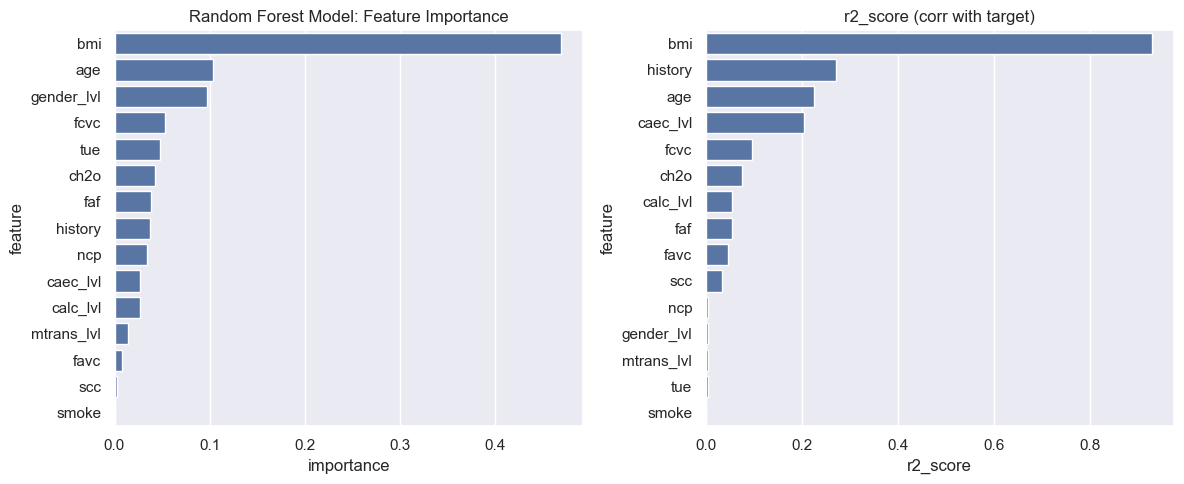

In [96]:
feature_importance = pd.DataFrame({'feature': X_norm.columns, 
                                   'importance': model_6_final.feature_importances_})
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(feature_importance.sort_values('importance', ascending=False),
            x='importance', y='feature', ax=axs[0])
axs[0].set_title('Random Forest Model: Feature Importance')
sns.barplot((r_score_final*r_score_final).reset_index().rename({0:'r2_score', 'index':'feature'}, axis=1).sort_values('r2_score', ascending=False),
            x='r2_score', y='feature', ax=axs[1])
axs[1].set_title('r2_score (corr with target)')
plt.tight_layout()
plt.show()

RF model successfully pick up importance of features like `gender` which do not show strong linear correlation with target.

In [97]:
# prepare model_6 submission file
y_pred = model_6_final.predict(X_test_norm)
df_model_6 = df_test_id.copy()
df_model_6['NObeyesdad'] = y_pred
df_model_6['NObeyesdad'] = df_model_6['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_6.to_csv('model_6_submission.csv', index=False)

#### **Model 7:** RF classifier (+ KNN result as feature)

If we use KNN model best result (from Model 3) as extra feature, will it help RF model score?  
Let's try.

In [98]:
X_train_norm_knn = X_train_norm.copy()
X_train_norm_knn['knn'] = model_3_tune.predict(X_train_norm_r) # use tuned model for splitted datasets to avoid data leak

X_val_norm_knn = X_val_norm.copy()
X_val_norm_knn['knn'] = model_3_tune.predict(X_val_norm_r)

X_norm_knn = X_norm.copy() # use final model full data
X_norm_knn['knn'] = model_3_final.predict(X_norm_r)

X_test_norm_knn = X_test_norm.copy()
X_test_norm_knn['knn'] = model_3_final.predict(X_test_norm_r)

In [99]:
model_7_default = RandomForestClassifier(random_state=314, n_jobs=-1)
# model_7_default.fit(X_train_norm_knn, y_train)

In [100]:
# pickle.dump(model_7_default, open('model_7_default.pickle', 'wb'))
model_7_default = pickle.load(open('model_7_default.pickle', 'rb'))

In [101]:
model_summary['id'].append(7)
model_summary['model'].append('RF clf')
model_summary['transformer'].append('PowerTransformer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_7_default.predict(X_val_norm_knn)))

print(f"RF classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

RF classifier (default) accuracy (val) = 85.6%


Looks not promising.

In [102]:
# hyper parameter tuning
rf_clf = RandomForestClassifier(random_state=314)
param_grid = {'n_estimators': [200, 300, 400, 500],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [None, 8, 16, 32],
              'min_samples_leaf': [1, 0.001, 0.0001, 0.0003]}
model_7_tune = GridSearchCV(rf_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_7_tune.fit(X_train_norm_knn, y_train)

In [103]:
# pickle.dump(model_7_tune, open('model_7_tune.pickle', 'wb'))
model_7_tune = pickle.load(open('model_7_tune.pickle', 'rb'))

In [104]:
model_7_tune.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [105]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_7_tune.predict(X_val_norm_knn)))
model_summary['comment'].append('Add Model 3 result as feature')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score
3,4,KNN reg,PowerTransformer*r,0.833141,0.836802,weight: r score
4,5,KNN clf,#3+Normalizer,0.826975,0.854721,
5,6,RF clf,PowerTransformer,0.884586,0.891908,
6,7,RF clf,PowerTransformer,0.856455,0.857418,Add Model 3 result as feature


In [106]:
# prepare final model
model_7_final = model_7_tune.best_estimator_
# model_7_final.fit(X_norm_knn, y)

In [107]:
# pickle.dump(model_7_final, open('model_7_final.pickle', 'wb'))
model_7_final = pickle.load(open('model_7_final.pickle', 'rb'))

In [108]:
# prepare model_7 submission file
y_pred = model_7_final.predict(X_test_norm_knn)
df_model_7 = df_test_id.copy()
df_model_7['NObeyesdad'] = y_pred
df_model_7['NObeyesdad'] = df_model_7['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_7.to_csv('model_7_submission.csv', index=False)

#### **Model 8:** XGB classifier

In [109]:
model_8_default = XGBClassifier(random_state=314, n_jobs=-1)
# model_8_default.fit(X_train_norm, y_train)

In [110]:
# pickle.dump(model_8_default, open('model_8_default.pickle', 'wb'))
model_8_default = pickle.load(open('model_8_default.pickle', 'rb'))

In [111]:
model_summary['id'].append(8)
model_summary['model'].append('XGB clf')
model_summary['transformer'].append('PowerTransformer')
model_summary['accuracy_default'].\
    append(metrics.accuracy_score(y_val, model_8_default.predict(X_val_norm)))

print(f"XGB classifier (default) accuracy (val) = {model_summary['accuracy_default'][-1]:.1%}")

XGB classifier (default) accuracy (val) = 89.3%


In [118]:
# hyper parameter tuning
xgb_clf = XGBClassifier(random_state=314)
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.05, 0.1, 0.2],
              'max_depth': [None, 4, 8, 16, 32],
              'min_child_weight': [1, 3, 10, 30]}
model_8_tune = GridSearchCV(xgb_clf, param_grid, cv=4, scoring=['accuracy'], 
                            refit='accuracy', n_jobs=-1)
# model_8_tune.fit(X_train_norm, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=314, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [None, 4, 8, 16, 32],
                         'min_child_weight': [1, 3, 10, 30],
                         'n_estimators': [100, 200, 300, 400, 500]},
             refit='accuracy', scoring=['accuracy'])

In [120]:
# pickle.dump(model_8_tune, open('model_8_tune.pickle', 'wb'))
model_8_tune = pickle.load(open('model_8_tune.pickle', 'rb'))

In [121]:
model_8_tune.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 10,
 'n_estimators': 300}

In [122]:
model_summary['accuracy_tuned'].\
    append(metrics.accuracy_score(y_val, model_8_tune.predict(X_val_norm)))
model_summary['comment'].append('')
pd.DataFrame(model_summary)

,id,model,transformer,accuracy_default,accuracy_tuned,comment
0,1,KNN clf,PowerTransformer,0.740655,0.777264,
1,2,KNN reg,PowerTransformer,0.721002,0.751060,
2,3,KNN clf,PowerTransformer*r,0.841426,0.856262,weight: r score
3,4,KNN reg,PowerTransformer*r,0.833141,0.836802,weight: r score
4,5,KNN clf,#3+Normalizer,0.826975,0.854721,
5,6,RF clf,PowerTransformer,0.884586,0.891908,
6,7,RF clf,PowerTransformer,0.856455,0.857418,Add Model 3 result as feature
7,8,XGB clf,PowerTransformer,0.892871,0.890944,


In [123]:
# prepare final model
model_8_final = model_8_tune.best_estimator_
# model_8_final.fit(X_norm, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [124]:
# pickle.dump(model_8_final, open('model_8_final.pickle', 'wb'))
model_8_final = pickle.load(open('model_8_final.pickle', 'rb'))

In [125]:
# prepare model_8 submission file
y_pred = model_8_final.predict(X_test_norm)
df_model_8 = df_test_id.copy()
df_model_8['NObeyesdad'] = y_pred
df_model_8['NObeyesdad'] = df_model_8['NObeyesdad'].apply(lambda x: nobeyesdad_list[x])
# df_model_8.to_csv('model_8_submission.csv', index=False)